# Download data

In [1]:
!wget  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip data_gsn.zip &> /dev/null
!rm data_gsn.zip

--2025-11-25 21:28:36--  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip [following]
--2025-11-25 21:28:37--  https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5544261 (5.3M) [application/zip]
Saving to: ‘data_gsn.zip’

data_gsn.zip        100%[===================>]   5.29M  2.21MB/s    in 2.4s    

2025-11-25 21:28:40 (2.21 MB/s) - ‘data_gsn.zip’ sav

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
import torch
import pandas as pd
import os
from itertools import combinations
from PIL import Image
from typing import Tuple, List, Dict
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import top_k_accuracy_score, f1_score, mean_absolute_error, root_mean_squared_error, accuracy_score, confusion_matrix
from IPython.display import clear_output
import seaborn as sns
torch.manual_seed(1)
np.random.seed(1)

# Create Dataset

In [3]:
class HWDataset(Dataset):
    def __init__(
        self, 
        dir: str, 
        transformations: transforms.Compose, 
        augmentations: bool=False, 
        indices: List[int] = None,
        num_augmentations: int=1,
        augmentation_prob: float=0.5
    ):
        """
        dir: path to folder containing images and labels.csv (e.g. 'data/')
        transform: optional torchvision transforms applied to the image tensor
        label_dtype: torch dtype for returned label tensor (counts)
        augmentation_prob: probability of applying each augemntation
        """
        self.img_labels = pd.read_csv(os.path.join(dir, "labels.csv"))
        self.img_dir = dir
        self.transformations = transformations


        self.map_combinations = list(combinations(range(6), 2))
        self.map_combinations = [tuple([i])+j for i in range(1, 10) for j in combinations(range(6), 2)]

        if indices is not None:
            self.img_labels = self.img_labels.iloc[indices].reset_index(drop=True)


        self.augmentations = augmentations
        self.num_aug = num_augmentations
        self.augmentation_prob = augmentation_prob

        if self.augmentations:
            self.perform_augmentations()    


    def __len__(self):
        return len(self.img_labels)
    

    def regression_to_classification(self, labels_regression: list):
        """Possible classes can be mapped to: `id of combination of indexes of non zero values` ((0, 1), (0, 2), ..., (4, 5)). times value of first non zero value"""
        
        non_zero_indexes = [i for i in range(len(labels_regression)) if labels_regression[i] != 0]
        first_non_zero_value = labels_regression[non_zero_indexes[0]]

        return self.map_combinations.index(tuple([first_non_zero_value]+non_zero_indexes))
    

    def apply_augmentation(self, image: Image.Image, label: list) -> Tuple[Image.Image, list]:
        """
        Apply augmentation to an image. Function chooses random combination of augmentations (but at least one)
        """
        # choose a random non-empty combination of the 5 augmentations
        # indices: 0=hflip, 1=vflip, 2=rotation, 3=brightness/contrast, 4=gaussian noise
        choices = np.random.rand(5) < self.augmentation_prob
        if not choices.any():
            choices[np.random.randint(0, 5)] = True

        # 1. Random horizontal flip
        # triangle right <-> triangle left
        if choices[0]:
            image = transforms.functional.hflip(image)
            label[3], label[5] = label[5], label[3]

        # 2. Random vertical 
        # triangle up <-> triangle down
        if choices[1]:
            image = transforms.functional.vflip(image)
            label[2], label[4] = label[4], label[2]
        
        # 3. Random k*90 deg rotation
        # `transforms.functional.rotate` rotates image counterclockwise, so 
        # right -> up -> left -> down -> right
        if choices[2]:
            k = int(np.random.choice([1, 2, 3]))
            image = transforms.functional.rotate(image, k * 90)
            for _ in range(k):
                label[2], label[3], label[4], label[5] = label[5], label[2], label[3], label[4]
        
        # 4. Random brightness/contrast
        # no label changes needed
        if choices[3]:
            brightness_factor = np.random.uniform(0.9, 1.1)
            image = transforms.functional.adjust_brightness(image, brightness_factor)

            contrast_factor = np.random.uniform(0.9, 1.1)
            image = transforms.functional.adjust_contrast(image, contrast_factor)

        # 5. Gaussian noise
        # No label changes needed
        if choices[4]:
            image_np = np.array(image)
            noise = np.random.normal(0, 5, image_np.shape)
            image_np = np.clip(image_np + noise, 0, 255).astype(np.uint8)
            image = Image.fromarray(image_np)

        return image, label
    

    def perform_augmentations(self):
        """Performs augmentations on dataset and saves new images"""
        new_rows = []

        for idx, row in self.img_labels.iterrows():
            filename = row.iloc[0]
            img_path = os.path.join(self.img_dir, filename)
            image = Image.open(img_path).convert("L")
            labels = row.iloc[1:].to_list()

            # keep original
            new_rows.append([filename] + labels)

            # create augmented versions
            for n in range(1, self.num_aug):
                img_aug, labels_aug = self.apply_augmentation(image.copy(), labels.copy())
                aug_name = f"{os.path.splitext(filename)[0]}_aug{n}{os.path.splitext(filename)[1]}"
                save_path = os.path.join(self.img_dir, aug_name)
                img_aug.save(save_path)
                new_rows.append([aug_name] + labels_aug)

        # replace img_labels with expanded dataframe
        self.img_labels = pd.DataFrame(new_rows, columns=self.img_labels.columns).reset_index(drop=True)
    

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        
        image = Image.open(img_path).convert("L")
        labels_cnt = self.img_labels.iloc[idx, 1:].to_list()

        if self.transformations:
            image = self.transformations(image)

        labels_cls = self.regression_to_classification(labels_cnt)
        labels_cnt = torch.tensor(labels_cnt, dtype=torch.float32)

        return image, labels_cls, labels_cnt

# Model deffinition

In [4]:
class HWModel(nn.Module):
    def __init__(self):

        super().__init__()

        self.backbone = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(64 * 28 * 28, 256), nn.ReLU()
        )

        self.head_cls = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(256, 64), 
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 135),
            nn.LogSoftmax(dim=1)
        )
        self.head_cnt = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(256, 64), 
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 6),
        )

    def forward(self, x):
        x = self.backbone(x)
        counts = self.head_cnt(x)
        log_probs = self.head_cls(x)

        return log_probs, counts

# Model training and testing

In [5]:
class HWTrainer:
    def __init__(
        self, 
        model: nn.Module,
        lambda_cnt: float=1,
        ignore_cls: bool=False,
        device: torch.device=None
    ):
        self.model = model
        self.lambda_cnt = lambda_cnt
        self.ignore_cls = ignore_cls

        self.device = device
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        self.loss_function_cls = nn.NLLLoss()
        self.loss_function_cnt = nn.SmoothL1Loss()

        self.classes = [
            "square",
            "circle",
            "traingle_up",
            "triangle_right",
            "triangle_down",
            "triangle_left"
        ]


    def compute_loss(
        self, 
        label_cls: torch.Tensor, 
        label_cnt: torch.Tensor, 
        out_cls: torch.Tensor, 
        out_cnt: torch.Tensor
    ) -> torch.Tensor:

        total_loss = 0
        if not self.ignore_cls:
            loss_cls = self.loss_function_cls(out_cls, label_cls)
            total_loss += loss_cls

        loss_cnt = self.loss_function_cnt(out_cnt, label_cnt)
        total_loss += self.lambda_cnt * loss_cnt
        return total_loss
    
            
    def train_epoch(self, train_loader: torch.utils.data.DataLoader) -> float:
        """Trains model for one epoch. Returns average loss from """
        self.model.train()
        total_loss = 0

        for images, labels_cls, labels_cnt in tqdm(train_loader, desc="Training"):
            images, labels_cls, labels_cnt = images.to(self.device), labels_cls.to(self.device), labels_cnt.to(self.device)

            out_cls, out_cnt = self.model(images)

            loss = self.compute_loss(labels_cls, labels_cnt, out_cls, out_cnt)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        return avg_loss
    
    
    def test_model(self, test_loader: torch.utils.data.DataLoader) -> Dict[str, float]:
        """
        Validation of model. Returns dict with all metrices described in assigment.
        """
        self.model.eval()
        total_loss = 0
        all_labels_cls = []
        all_labels_cnt = []
        all_preds_cls = []
        all_preds_cnt = []

        with torch.no_grad():
            for images, labels_cls, labels_cnt in tqdm(test_loader, desc='Validating'):
                images = images.to(self.device)
                labels_cls, labels_cnt = labels_cls.to(self.device), labels_cnt.to(self.device)

                out_cls, out_cnt = self.model(images)
                
                total_loss += self.compute_loss(labels_cls, labels_cnt, out_cls, out_cnt).item()

                out_cls = torch.exp(out_cls)

                all_labels_cls.append(labels_cls.cpu().numpy())               
                all_labels_cnt.append(labels_cnt.cpu().numpy())
                all_preds_cls.append(out_cls.cpu().numpy())
                all_preds_cnt.append(out_cnt.cpu().numpy())

        avg_loss = total_loss / len(test_loader)

        all_labels_cls = np.concatenate(all_labels_cls)
        all_labels_cnt = np.concatenate(all_labels_cnt)
        all_preds_cls = np.concatenate(all_preds_cls)
        all_preds_cnt = np.concatenate(all_preds_cnt)
        
        
        # Classification metrics
        labels = np.arange(all_preds_cls.shape[1])
        top1_accuracy = top_k_accuracy_score(all_labels_cls, all_preds_cls, k=1, labels=labels)
        predicted_classes = np.argmax(all_preds_cls, axis=1)
        f1 = f1_score(all_labels_cls, predicted_classes, average='macro')
        conf_mat = confusion_matrix(all_labels_cls, predicted_classes, labels=labels)        

        # per pair accuracy
        # print(predicted_classes)
        per_pair_true = [i % 15 for i in all_labels_cls]
        per_pair_preds = [i % 15 for i in predicted_classes]
        per_pair_accuracy = accuracy_score(per_pair_true, per_pair_preds)

        # Regression overall metrics
        rmse_overall = root_mean_squared_error(all_labels_cnt, all_preds_cnt)
        mae_overall = mean_absolute_error(all_labels_cnt, all_preds_cnt)

        # store on the trainer for later inspection/plotting
        validation_dict = {
            "test_loss": avg_loss,
            "Top1_accuracy": top1_accuracy,
            "Macro_F1_score": f1,
            "confusion_matrix": conf_mat,
            "per_pair_accuracy": per_pair_accuracy,
            "RMSE_overall": rmse_overall,
            "MAE_overall": mae_overall,
        }

        # Regression perclass metrics
        for i in range(6):
            validation_dict.update({f"MAE_{self.classes[i]}": mean_absolute_error(all_labels_cnt[:, i], all_preds_cnt[:, i])})
            validation_dict.update({f"RMSE_{self.classes[i]}": root_mean_squared_error(all_labels_cnt[:, i], all_preds_cnt[:, i])})

        return validation_dict
    

    def train(
        self,
        train_loader: torch.utils.data.DataLoader,
        test_loader: torch.utils.data.DataLoader,
        num_epochs: int=100,
        patience: int=5,
    ) -> Dict[str, List[float]]:
        """
        Full training loop with early stopping.
        Returns Dict of lists with values for validation metrics and training loss for every epoch.
        """
        history = {
            "test_loss": [],
            "train_loss": [],
            "Top1_accuracy": [],
            "Macro_F1_score": [],
            "confusion_matrix": [],
            "per_pair_accuracy": [],
            "RMSE_overall": [],
            "MAE_overall": [],
        }
        for i in range(6):
            history.update({f"MAE_{self.classes[i]}": []})
            history.update({f"RMSE_{self.classes[i]}": []})

        best_test_loss = 999_999_999
        best_model_state = None
        patience_counter = 0

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")

            train_loss = self.train_epoch(train_loader)
            history['train_loss'].append(train_loss)

            test_metrics = self.test_model(test_loader)

            # Print metrices
            clear_output(wait=False)
            print(f"Training loss: {train_loss:.4f}")
            for i in test_metrics:
                if i != "confusion_matrix":
                    print(f"{i}: {test_metrics[i]}")
                history[i].append(test_metrics[i])

            # Early stopping
            test_loss = test_metrics["test_loss"]
            # If current model performs worse than before
            if test_loss > best_test_loss:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping after {epoch+1} epochs")
                    # Restore best model
                    self.model.load_state_dict(best_model_state)
                    break
            else:
                patience_counter = 0
                best_test_loss = test_loss
                best_model_state = self.model.state_dict().copy()

        return history

# Load data

In [6]:
TRAIN_SIZE = 9000
TEST_SIZE = 1000
DATA_DIR = "data/"
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000

train_indices = list(range(TRAIN_SIZE))
test_indices = list(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = HWDataset(
    dir=DATA_DIR,
    transformations=transform,
    augmentations=True,
    augmentation_prob=0.5,
    num_augmentations=3,
    indices=train_indices,
)

test_dataset = HWDataset(
    dir=DATA_DIR,
    transformations=transform,
    indices=test_indices,
    augmentations=False
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Experiments
## Experiment 1 - classification only

In [8]:
%%time
model = HWModel()
model = model.to(device)
trainer = HWTrainer(model=model, lambda_cnt=0, ignore_cls=False, device=device)
experiment_1 = trainer.train(train_loader, test_loader, patience=15)
experiment_1_final_values = trainer.test_model(test_loader)

Training loss: 0.8546
test_loss: 2.314044952392578
Top1_accuracy: 0.315
Macro_F1_score: 0.2947401886691495
per_pair_accuracy: 0.792
RMSE_overall: 2.9744443893432617
MAE_overall: 1.9719452857971191
MAE_square: 1.7982146739959717
RMSE_square: 2.6830270290374756
MAE_circle: 2.082571268081665
RMSE_circle: 3.2778091430664062
MAE_traingle_up: 1.8955293893814087
RMSE_traingle_up: 2.9990522861480713
MAE_triangle_right: 1.8228979110717773
RMSE_triangle_right: 2.854081392288208
MAE_triangle_down: 2.277249574661255
RMSE_triangle_down: 3.230469226837158
MAE_triangle_left: 1.9552111625671387
RMSE_triangle_left: 2.802227258682251
Early stopping after 24 epochs


Validating: 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

CPU times: user 3min 36s, sys: 4.51 s, total: 3min 41s
Wall time: 3min 42s


## Experiment 2 - regression only

In [9]:
%%time
model = HWModel()
model = model.to(device)
trainer = HWTrainer(model=model, lambda_cnt=1, ignore_cls=True, device=device)
experiment_2 = trainer.train(train_loader, test_loader, patience=15)
experiment_2_final_values = trainer.test_model(test_loader)

Training loss: 0.2248
test_loss: 0.3969997465610504
Top1_accuracy: 0.008
Macro_F1_score: 0.0025952355738029873
per_pair_accuracy: 0.044
RMSE_overall: 1.0929163694381714
MAE_overall: 0.6449913382530212
MAE_square: 0.35867419838905334
RMSE_square: 0.6515265107154846
MAE_circle: 0.32262706756591797
RMSE_circle: 0.6014664173126221
MAE_traingle_up: 0.8190199136734009
RMSE_traingle_up: 1.3390170335769653
MAE_triangle_right: 0.7584162950515747
RMSE_triangle_right: 1.2909493446350098
MAE_triangle_down: 0.7733961343765259
RMSE_triangle_down: 1.3208482265472412
MAE_triangle_left: 0.8378153443336487
RMSE_triangle_left: 1.3536921739578247
Early stopping after 19 epochs


Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Validating: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

CPU times: user 2min 53s, sys: 3.22 s, total: 2min 56s
Wall time: 2min 57s


## Experiment 3 - classification and regression

In [10]:
%%time
model = HWModel()
model = model.to(device)
trainer = HWTrainer(model=model, lambda_cnt=5, ignore_cls=False, device=device)
experiment_3 = trainer.train(train_loader, test_loader, patience=15)
experiment_3_final_values = trainer.test_model(test_loader)

Training loss: 1.5782
test_loss: 4.190117835998535
Top1_accuracy: 0.315
Macro_F1_score: 0.2977383221259536
per_pair_accuracy: 0.819
RMSE_overall: 1.038758397102356
MAE_overall: 0.6261641383171082
MAE_square: 0.38334760069847107
RMSE_square: 0.6045647859573364
MAE_circle: 0.3224188983440399
RMSE_circle: 0.5880136489868164
MAE_traingle_up: 0.7296493053436279
RMSE_traingle_up: 1.236746907234192
MAE_triangle_right: 0.7758870720863342
RMSE_triangle_right: 1.3631559610366821
MAE_triangle_down: 0.7474287748336792
RMSE_triangle_down: 1.1850987672805786
MAE_triangle_left: 0.7982536554336548
RMSE_triangle_left: 1.2549690008163452
Early stopping after 22 epochs


Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Validating: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

CPU times: user 3min 20s, sys: 3.48 s, total: 3min 23s
Wall time: 3min 25s


# Create plots and tables

In [11]:
final_values_df = pd.DataFrame([pd.Series(i) for i in [experiment_1_final_values, experiment_2_final_values, experiment_3_final_values]], )
final_values_df.index = ['exp1', 'exp2', 'exp3']
final_values_df

,test_loss,Top1_accuracy,Macro_F1_score,confusion_matrix,per_pair_accuracy,RMSE_overall,MAE_overall,MAE_square,RMSE_square,MAE_circle,RMSE_circle,MAE_traingle_up,RMSE_traingle_up,MAE_triangle_right,RMSE_triangle_right,MAE_triangle_down,RMSE_triangle_down,MAE_triangle_left,RMSE_triangle_left
exp1,2.314045,0.315,0.294740,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.792,2.974444,1.971945,1.798215,2.683027,2.082571,3.277809,1.895529,2.999052,1.822898,2.854081,2.277250,3.230469,1.955211,2.802227
exp2,0.397000,0.008,0.002595,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.044,1.092916,0.644991,0.358674,0.651527,0.322627,0.601466,0.819020,1.339017,0.758416,1.290949,0.773396,1.320848,0.837815,1.353692
exp3,4.190118,0.315,0.297738,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.819,1.038758,0.626164,0.383348,0.604565,0.322419,0.588014,0.729649,1.236747,0.775887,1.363156,0.747429,1.185099,0.798254,1.254969


In [12]:
# select only the required columns (corrected spelling)
cols = ["test_loss", "Top1_accuracy", "per_pair_accuracy", "RMSE_overall", "MAE_overall"]
final_values_df = final_values_df[cols]
md_table = final_values_df.to_markdown()
with open("final_metrics_table.md", "w") as f:
    f.write(md_table)
final_values_df

,test_loss,Top1_accuracy,per_pair_accuracy,RMSE_overall,MAE_overall
exp1,2.314045,0.315,0.792,2.974444,1.971945
exp2,0.397000,0.008,0.044,1.092916,0.644991
exp3,4.190118,0.315,0.819,1.038758,0.626164


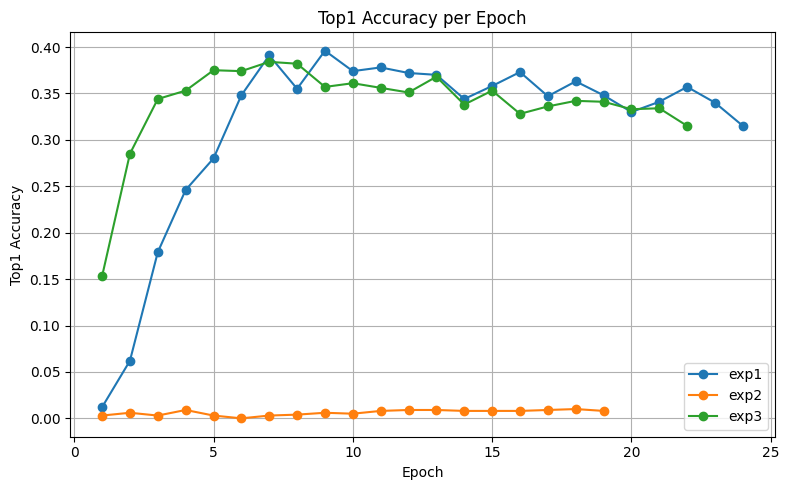

In [13]:
import numpy as np

import matplotlib.pyplot as plt

acc1 = experiment_1.get("Top1_accuracy", [])
acc2 = experiment_2.get("Top1_accuracy", [])
acc3 = experiment_3.get("Top1_accuracy", [])

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(acc1) + 1), acc1, marker='o', label='exp1')
plt.plot(np.arange(1, len(acc2) + 1), acc2, marker='o', label='exp2')
plt.plot(np.arange(1, len(acc3) + 1), acc3, marker='o', label='exp3')
plt.xlabel("Epoch")
plt.ylabel("Top1 Accuracy")
plt.title("Top1 Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

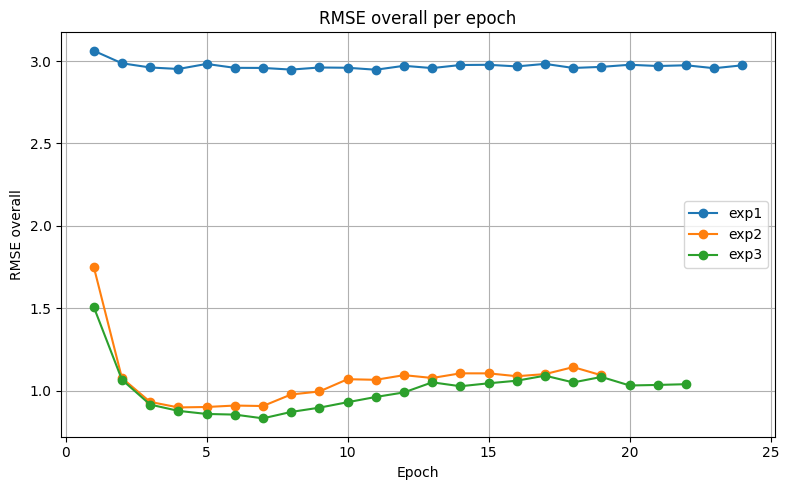

In [14]:
acc1 = experiment_1.get("RMSE_overall", [])
acc2 = experiment_2.get("RMSE_overall", [])
acc3 = experiment_3.get("RMSE_overall", [])

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(acc1) + 1), acc1, marker='o', label='exp1')
plt.plot(np.arange(1, len(acc2) + 1), acc2, marker='o', label='exp2')
plt.plot(np.arange(1, len(acc3) + 1), acc3, marker='o', label='exp3')
plt.xlabel("Epoch")
plt.ylabel("RMSE overall")
plt.title("RMSE overall per epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

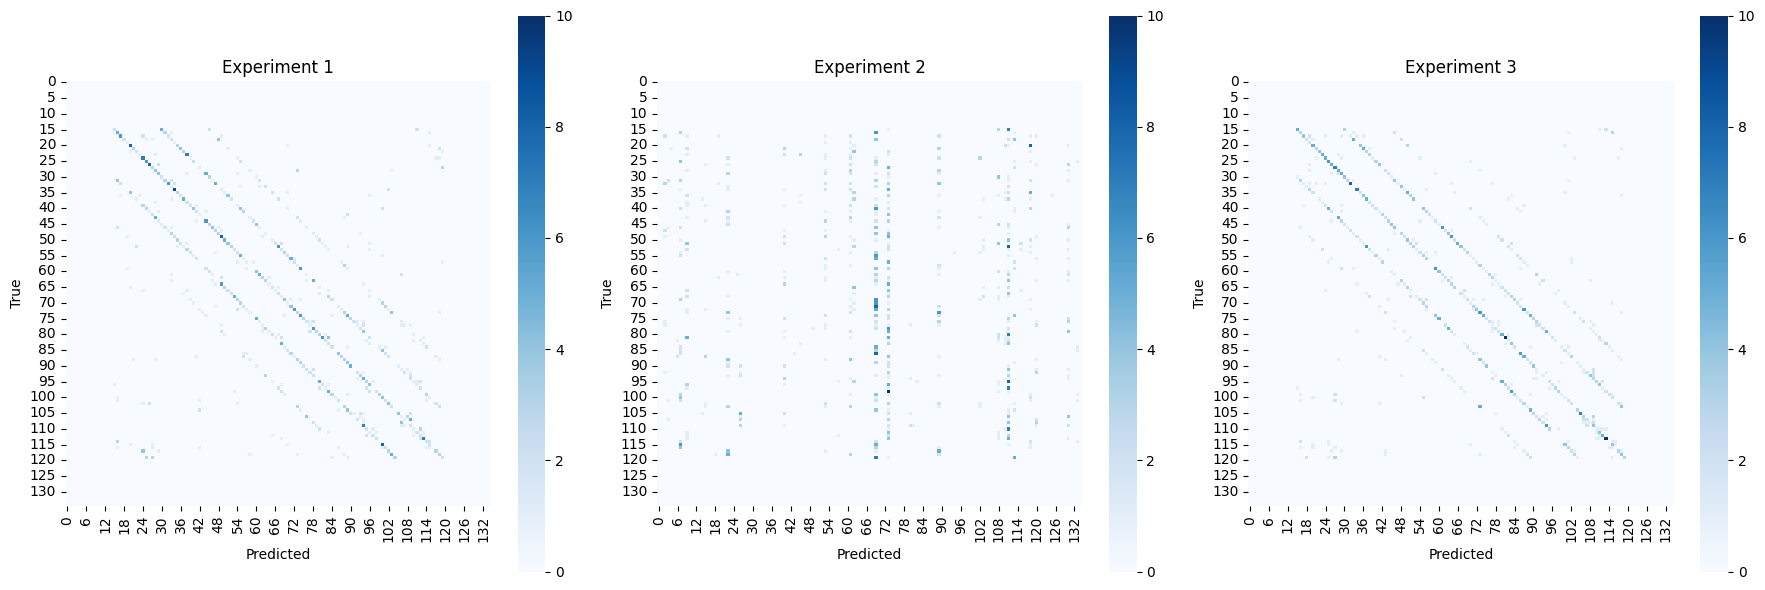

In [ ]:
cm1 = np.array(experiment_1_final_values["confusion_matrix"])
cm2 = np.array(experiment_2_final_values["confusion_matrix"])
cm3 = np.array(experiment_3_final_values["confusion_matrix"])

cms = [cm1, cm2, cm3]
titles = ["Experiment 1", "Experiment 2", "Experiment 3"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(cm, ax=ax, cmap="Blues", cbar=True, square=True)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.savefig("confusion_matrices.png", dpi=150)
plt.show()